In [1]:
import numpy as np
import pandas as pd
from scipy import signal,fftpack
import cv2
from skimage.io import imread
import matplotlib.pyplot as plt
import IPython.display as ipd
import os

from matplotlib.figure import Figure
from skimage import color, data, restoration
from scipy.signal import convolve2d
from math import log10, sqrt

import librosa

In [2]:
!wget https://drive.google.com/uc?id=1dhh4m9VRLUSmbaHfge2iRSW5Azkpefco  -O kitty3.png
!wget https://drive.google.com/uc?id=1o0UMPTyUFzX9CaQp-BwYXgkCho1Zo6yL  -O kitty55.png
!wget https://drive.google.com/uc?id=1Jk0cEtQt4HxkLcKlmTHukpb22gJZ4dmL -O noisy_kitty55.png
!wget https://drive.google.com/uc?id=1xCNA5338nzj1GgGQ5-oBA1dKCW1Mvn21 -O hillbefore_noise10%.jpg

--2023-10-11 03:36:11--  https://drive.google.com/uc?id=1dhh4m9VRLUSmbaHfge2iRSW5Azkpefco
Resolving drive.google.com (drive.google.com)... 74.125.195.139, 74.125.195.102, 74.125.195.138, ...
Connecting to drive.google.com (drive.google.com)|74.125.195.139|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0dsecequg098mcv8dqp2v177gj97v306/1696995300000/10800959494545164832/*/1dhh4m9VRLUSmbaHfge2iRSW5Azkpefco?uuid=bb312b35-e294-4568-b065-e1f9eb4543ce [following]
--2023-10-11 03:36:11--  https://doc-04-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/0dsecequg098mcv8dqp2v177gj97v306/1696995300000/10800959494545164832/*/1dhh4m9VRLUSmbaHfge2iRSW5Azkpefco?uuid=bb312b35-e294-4568-b065-e1f9eb4543ce
Resolving doc-04-2o-docs.googleusercontent.com (doc-04-2o-docs.googleusercontent.com)... 74.125.195.132, 2607:f8b0:400e:c09::84
Connecting to doc-04

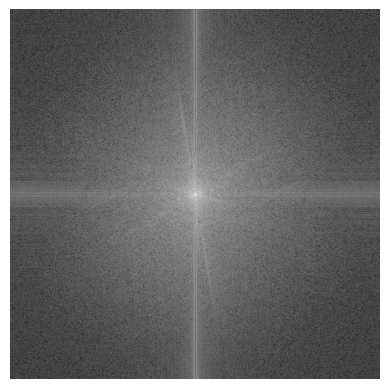

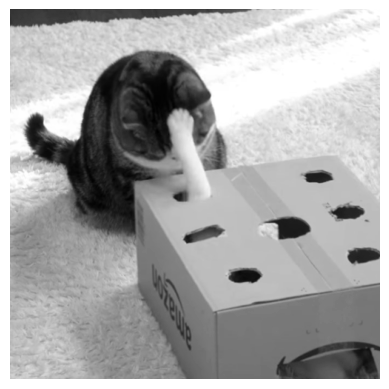

In [3]:
kitty55 = cv2.imread("kitty55.png")
kitty55 = cv2.cvtColor(kitty55,cv2.COLOR_BGR2GRAY).astype(float)

ff_kitty55 = np.fft.fft2(kitty55)
fftshift_kitty = np.fft.fftshift(ff_kitty55)
mag = (np.log( 1 + np.abs(fftshift_kitty))).astype(int)

plt.imshow( mag, cmap='gray')
plt.axis(False)
plt.show()
plt.imshow(kitty55,cmap = 'gray')
plt.axis(False)
plt.show()

alpha: 99.03514418234892
Cut off freq: 16


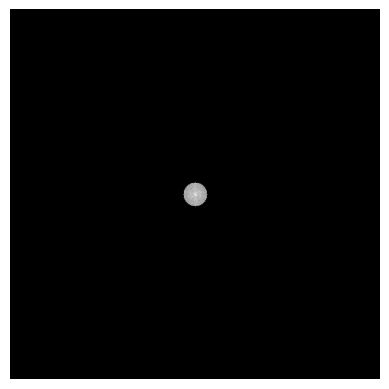

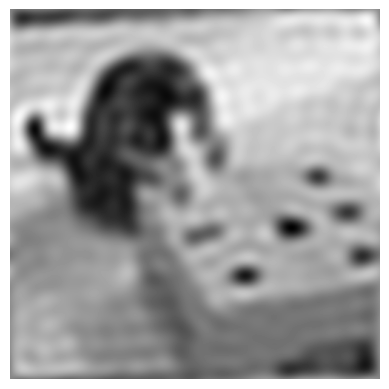

In [4]:
rows, cols = kitty55.shape
center_row, center_col = int(rows / 2), int(cols / 2)
for C in range(1,min(rows, cols) // 2):
    u, v = np.meshgrid(np.arange(rows), np.arange(cols))

    distance = np.sqrt((u - center_row)**2 + (v - center_col)**2)

    ideal_low_pass_filter = np.zeros((rows,cols))
    ideal_low_pass_filter[distance <= C] = 1

    fftshift_fitered_kitty = fftshift_kitty * ideal_low_pass_filter

    PT_org = np.sum(np.abs(fftshift_kitty)**2)
    PT_filtered = np.sum(np.abs(fftshift_fitered_kitty)**2)
    alpha = (PT_filtered * 100) / PT_org

    if alpha > 99:
        print('alpha:' , alpha)
        print('Cut off freq:', C)
        break

image_filtered = np.fft.ifft2(np.fft.ifftshift(fftshift_fitered_kitty))

plt.imshow((np.log( 1 + np.abs(fftshift_fitered_kitty))).astype(int), cmap='gray')
plt.axis(False)
plt.show()
plt.imshow(np.real(image_filtered), cmap='gray')
plt.axis(False)
plt.show()

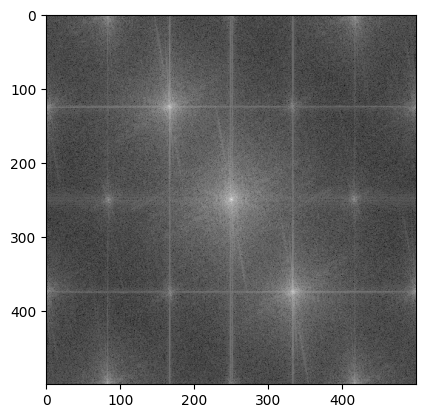

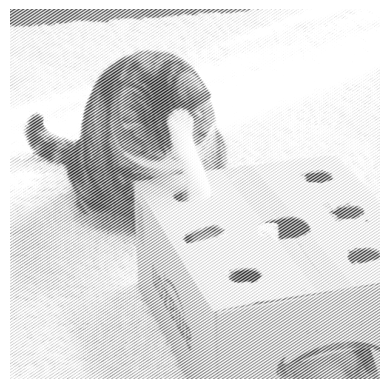

In [5]:
noisy_kitty55 = cv2.imread("noisy_kitty55.png")
noisy_kitty55 = cv2.cvtColor(noisy_kitty55,cv2.COLOR_BGR2GRAY).astype(float)

ff_noisy_kitty55 = np.fft.fft2(noisy_kitty55)
fftshift_noisy_kitty = np.fft.fftshift(ff_noisy_kitty55)
mag = (np.log( 1 + np.abs(fftshift_noisy_kitty))).astype(int)

plt.imshow( mag, cmap='gray')
plt.show()
plt.imshow(noisy_kitty55,cmap = 'gray')
plt.axis(False)
plt.show()


In [6]:
def contrast_stretching(image_grayscale):
    # input -> image_grayscale - type -> np.ndarray, size of - (height, width)
    # output -> image_grayscale - type -> np.ndarray, size of - (height, width)

    # TO DO - Implement transformation based on the contrast stretching graph

    filtered_image = np.zeros_like(image_grayscale)

    def pixelVal(pix, r1, s1, r2, s2):
        if (0 <= pix and pix <= r1):
            return (s1 / r1)*pix
        elif (r1 < pix and pix <= r2):
            return ((s2 - s1)/(r2 - r1)) * (pix - r1) + s1
        else:
            return ((255 - s2)/(255 - r2)) * (pix - r2) + s2

    (x,y) = image_grayscale.shape

    r1 = 50
    s1 = 0
    r2 = 225
    s2 = 255

    for x1 in range(x):
        for y1 in range(y):
            filtered_image[x1,y1] = pixelVal(image_grayscale[x1,y1], r1, s1, r2, s2)

    return filtered_image

def PSNR(original, estimate):
    mse = np.mean((original - estimate) ** 2)
    if(mse == 0):  # MSE is zero means no noise is present in the signal .
                  # Therefore PSNR have no importance.
        return 100
    max_pixel = np.max(original) # 255, 1
    psnr = 20 * log10(max_pixel / sqrt(mse))
    # plt.subplot(1,2,1)
    # plt.imshow(original,cmap="gray")
    # plt.subplot(1,2,2)
    # plt.imshow(estimate,cmap="gray")
    # plt.show()
    return psnr

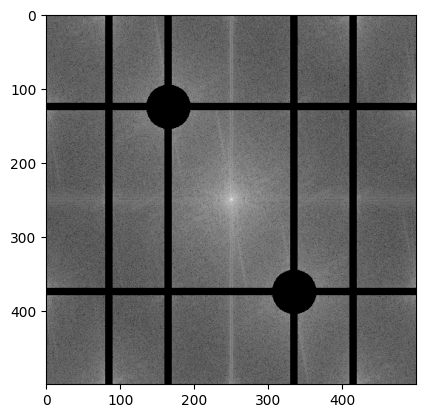

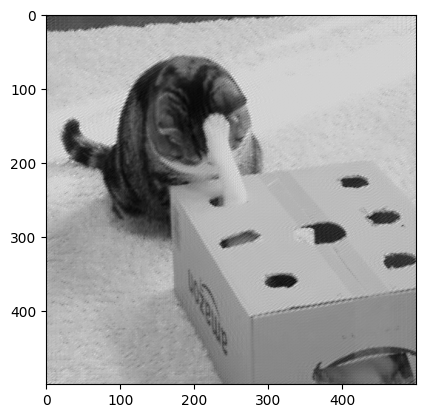

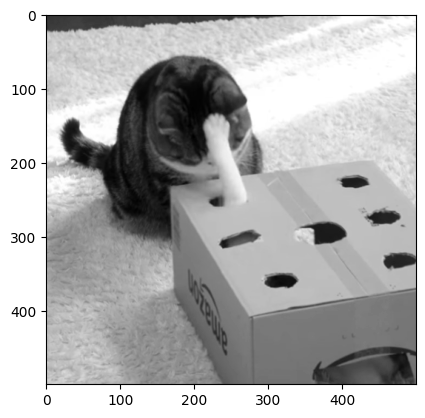

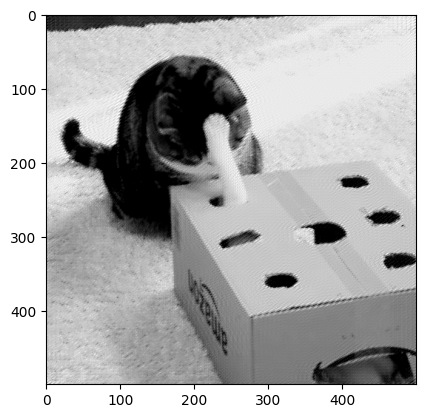

23.408149857173775
10.51428977093491


In [7]:
import cv2

ff_noisy_kitty55 = np.fft.fft2(noisy_kitty55)
fftshift_noisy_kitty = np.fft.fftshift(ff_noisy_kitty55)
fftshift_noisy_kitty[:,80:90] = 0
fftshift_noisy_kitty[:,160:170] = 0
fftshift_noisy_kitty[:,330:340] = 0
fftshift_noisy_kitty[:,410:420] = 0
fftshift_noisy_kitty[120:130,:] = 0
fftshift_noisy_kitty[370:380,:] = 0

center_x1, center_y1 = 125,165  # coordinates of the notch filter
center_x2, center_y2 = 375,335
radius = 30  # radius of the circular mask

# Create a mask with a notch at the specified coordinates and radius
rows, cols = fftshift_noisy_kitty.shape
center1 = [center_x1, center_y1]
center2 = [center_x2, center_y2]
x, y = np.ogrid[:rows, :cols]
mask_area1 = (x - center1[0]) ** 2 + (y - center1[1]) ** 2 <= radius*radius
mask_area2 = (x - center2[0]) ** 2 + (y - center2[1]) ** 2 <= radius*radius
fftshift_noisy_kitty[mask_area1] = 0
fftshift_noisy_kitty[mask_area2] = 0

# plt.imshow(mask_area ,cmap="gray")
# plt.show()

image_filtered = np.real(np.fft.ifft2(np.fft.ifftshift(fftshift_noisy_kitty)))
image_filtered  = (image_filtered - image_filtered.min()) / (image_filtered.max()-image_filtered.min()) * 255
image_filtered = np.power(image_filtered / 255.0, 1.1) * 255.0
contrast_img = contrast_stretching(image_filtered).astype(np.uint8)
mag = (np.log( 1 + np.abs(fftshift_noisy_kitty))).astype(int)

plt.imshow( mag, cmap='gray')
plt.show()
plt.imshow( image_filtered, cmap='gray')
plt.show()
plt.imshow( kitty55, cmap='gray')
plt.show()
plt.imshow( contrast_img, cmap='gray')
plt.show()

print(PSNR(kitty55,contrast_img))
print(PSNR(kitty55,noisy_kitty55))

In [8]:
noisy_image = cv2.imread('noisy_kitty55.png', cv2.IMREAD_GRAYSCALE)
original_image = cv2.imread('kitty55.png', cv2.IMREAD_GRAYSCALE)

def psnr(original, noisy):
    mse = np.mean((original - noisy) ** 2)
    if mse==0: return 100
    max_pixel = 255.0
    psnr = 20 * np.log10(max_pixel / np.sqrt(mse))
    return psnr

print(f"PSNR: {PSNR(original_image, noisy_image)}")
print(f"PSNR: {PSNR(original_image, contrast_img)}")

PSNR: 28.777556580091797
PSNR: 29.288480987506436


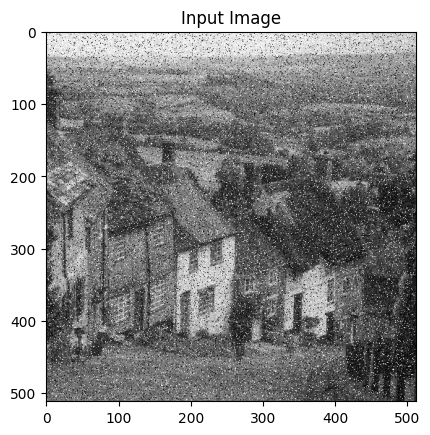

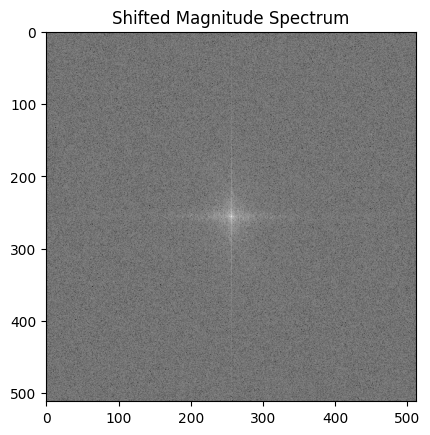

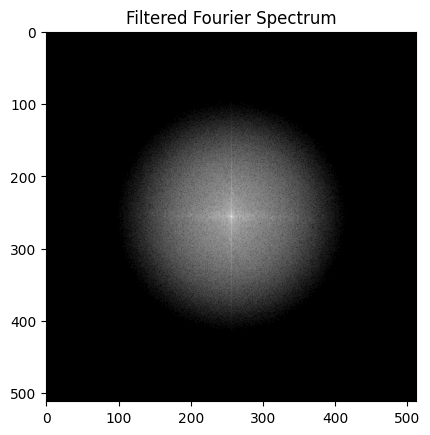

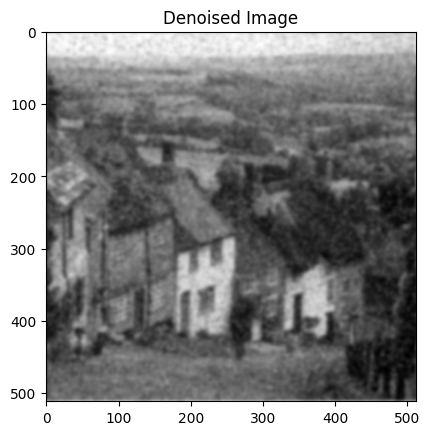

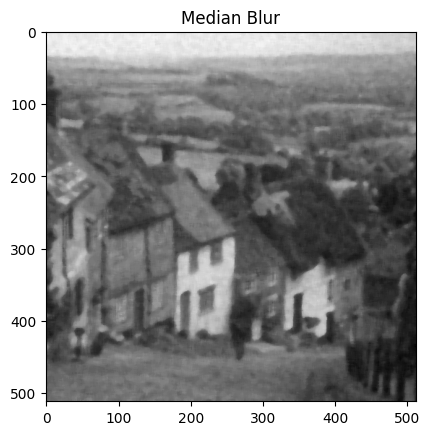

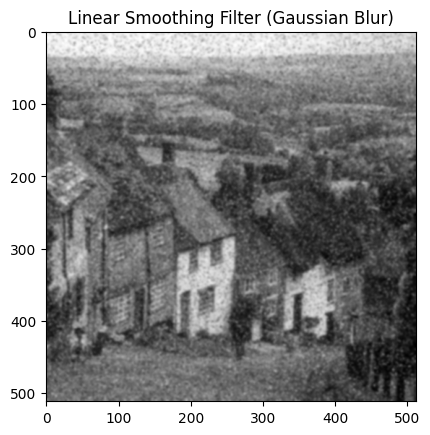

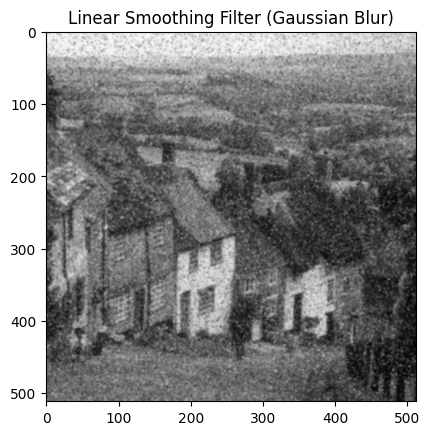

In [9]:
hillbefore_noise10 = cv2.imread("hillbefore_noise10%.jpg",cv2.IMREAD_GRAYSCALE)
# hillbefore_noise10 = cv2.cvtColor(hillbefore_noise10 ,cv2.COLOR_BGR2GRAY).astype(float)
plt.imshow(hillbefore_noise10,cmap="gray")
plt.title("Input Image")
plt.show()

fft_house = np.fft.fft2(hillbefore_noise10)
fftshift_house = np.fft.fftshift(fft_house)
mag = (np.log( 1 + np.abs(fftshift_house))).astype(int)

plt.imshow(mag,cmap="gray")
plt.title("Shifted Magnitude Spectrum")
plt.show()

rows, cols = hillbefore_noise10.shape
center_x, center_y = rows // 2, cols // 2
D0 = 35  # Cutoff frequency
x, y = np.ogrid[:rows, :cols]
mask = np.exp(-((x - center_x) ** 2 + (y - center_y) ** 2) / (2 * (D0 ** 2)))
fft_filtered_house = fftshift_house * mask
filtered_mag = (np.log( 1 + np.abs(fft_filtered_house))).astype(int)

plt.imshow(filtered_mag,cmap="gray")
plt.title("Filtered Fourier Spectrum")
plt.show()

filtered_house = np.real(np.fft.ifft2(np.fft.ifftshift(fft_filtered_house)))

plt.imshow(filtered_house,cmap="gray")
plt.title("Denoised Image")
plt.show()

median_blur_image = cv2.medianBlur(hillbefore_noise10, 7)
plt.imshow(median_blur_image,cmap="gray")
plt.title("Median Blur")
plt.show()

gaussian_blur_image = cv2.GaussianBlur(hillbefore_noise10, (7,7), 0)
plt.imshow(gaussian_blur_image,cmap="gray")
plt.title("Linear Smoothing Filter (Gaussian Blur)")
plt.show()

gaussian_blur_image = cv2.GaussianBlur(hillbefore_noise10, (5, 5), 0)
plt.imshow(gaussian_blur_image,cmap="gray")
plt.title("Linear Smoothing Filter (Gaussian Blur)")
plt.show()